# Synthetic Human Contact Network

This is the first step in creating the Urban Transportation Disease Spread Simulator. Synthetic Human Contact Network is the backbone of the simulator (TranEpiSim). I utilized the methodology proposed by [**Burger et al. (2017)**](https://dl.acm.org/doi/abs/10.1145/3145574.3145593?casa_token=z6J9RUlCP3UAAAAA:7Ie0L7W9_bmIsaR9JHfutQgyYJ9aIj0dC2ZnuGhQaF4x46QOczVq1FwfH7dsDloAcwDCH26pjOM) to create a large-scale human contact network adapted for a disease system. The code for constructing the network was obtained from **Talha Oz's** Jupyter notebook repository, which provides detailed instructions and can be accessed [**here**](https://nbviewer.org/gist/oztalha/a1c167f3879c5b95f721acef791c8111/Population%20Synthesis%20for%20ABM.ipynb). It has wondeful instructions and you can start from there if you want to develop a network for your own application. I will provide concise instructions and details for this notebook unless changes are made to the network.



## 1. Install requirements


* graph-tool documentation:

    https://graph-tool.skewed.de/static/doc/index.html
* See here for instructions how to install graph-tool on different platforms, including Colab:

    https://graph-tool.skewed.de/static/doc/index.html#installing-graph-tool

    https://git.skewed.de/count0/graph-tool/-/wikis/installation-instructions

* To import a library that's not in Colaboratory by default, you can use !apt-get install. Since graph-tool is not in the official repository, we need to add it to the list.

In [1]:
!echo "deb http://downloads.skewed.de/apt focal main" >> /etc/apt/sources.list
!apt-key adv --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib python3-cairo

Executing: /tmp/apt-key-gpghome.zS4q8XKnDN/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
gpg: key 612DEFB798507F25: public key "Tiago de Paula Peixoto <tiago@skewed.de>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:4 http://downloads.skewed.de/apt focal InRelease [7,536 B]
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:6 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Hit:10 http://archive.ubuntu.com/ubuntu focal InRelease
G

In [2]:
# Colab uses a Python install that deviates from the system's! Bad collab! We need some workarounds.
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be REMOVED:
  python3-cairo*
0 upgraded, 0 newly installed, 1 to remove and 15 not upgraded.
After this operation, 270 kB disk space will be freed.
(Reading database ... 126596 files and directories currently installed.)
Removing python3-cairo:amd64 (1.16.2-2ubuntu2) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
pkg-config is already the newest version (0.29.1-0ubuntu4).
python3-dev is already the newest version (3.8.2-0ubuntu2).
python3-dev set to manually installed.
The following additional packages will be installed:
  libblkid-dev libblkid1 libcairo-script-interpreter2 libffi-dev
  libglib2.0-dev libglib2.0-dev-bin liblzo2-2 libmount-dev libmount1
  libpixman-1-dev libselinux1-dev libsepol1-dev libxcb-render0-dev
  libxcb-shm0-dev
Suggested packages:
  libcairo2-doc libgirepository1.0-dev libglib2.0-doc lib

In [3]:
!pip install signatory # May take some time...

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for signatory: filename=signatory-1.2.6.1.9.0-cp310-cp310-linux_x86_64.whl size=13908454 sha256=2082fc4708058fdbcdedff187025c25fd4813d993e081678aea00c0d6d278be8
  Stored in directory: /root/.cache/pip/wheels/71/b4/17/46d769da4808e9f83f9790a2b805f81f43ececc2c02f5b1e62
Successfully built signatory


In [4]:
!pip install pandas geopandas mapclassify rtree simpledbf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for simpledbf: filename=simpledbf-0.2.6-py3-none-any.whl size=13785 sha256=d1d9a7326f884361d663fb4f13fcccf901be8d4aad01a4cb425ace7eb396eb5d
  Stored in directory: /root/.cache/pip/wheels/e5/41/13/ebdef29165b9309ec4e235dbff19eca8b6759125b0924ad430
Successfully built simpledbf


In [5]:
!apt-get install gtk+3

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libcaribou-gtk3-module' for regex 'gtk+3'
Note, selecting 'libgtk3.0-cil-dev' for regex 'gtk+3'
Note, selecting 'libghc-gtk3-dev-0.15.1-9336f' for regex 'gtk+3'
Note, selecting 'spacefm-gtk3' for regex 'gtk+3'
Note, selecting 'libghc-gtk3-prof' for regex 'gtk+3'
Note, selecting 'libdbusmenu-gtk3-dev' for regex 'gtk+3'
Note, selecting 'gtk3-engines-breeze' for regex 'gtk+3'
Note, selecting 'libgtk3-webkit2-perl' for regex 'gtk+3'
Note, selecting 'python-wxgtk3.0-dev' for regex 'gtk+3'
Note, selecting 'uim-gtk3-immodule' for regex 'gtk+3'
Note, selecting 'libreoffice-gtk3' for regex 'gtk+3'
Note, selecting 'fcitx5-frontend-gtk3' for regex 'gtk+3'
Note, selecting 'monodoc-gtk3.0-manual' for regex 'gtk+3'
Note, selecting 'libcanberra-gtk3-dev' for regex 'gtk+3'
Note, selecting 'ruby-gtk3' for regex 'gtk+3'
Note, selecting 'packagekit-gtk3-module' for regex 'gtk+3'
Note, selectin

In [6]:
!pip install seaborn plotly

## 2. Add required packages


* See the Requirement.txt for all required packages.
* To utilize Google Colaboratory, it is necessary to mount your Google Drive.

In [7]:
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


In [8]:
# General:
import os
import sys
import multiprocessing
from multiprocessing import pool
from multiprocessing import *
from io import StringIO
from IPython.display import display, HTML, Image
import numpy as np
import pandas as pd
import pickle
import datetime as dt
from datetime import timedelta, date
import timeit
import gzip
import shutil
from functools import partial
from dateutil.parser import parse
from concurrent.futures import ThreadPoolExecutor
from itertools import chain
from glob import glob
from sklearn.preprocessing import normalize
import random
# import rtree
import mapclassify

# Spatial:
import geopandas as gpd
from shapely.prepared import prep
from shapely.ops import snap, linemerge, nearest_points
from shapely.geometry import MultiLineString, LineString, Point, Polygon, GeometryCollection
# import pygeos

# Visualization:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as ani
from matplotlib import rc
import matplotlib.dates as mdates
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Graph analyses:
from graph_tool.all import graph_tool as gt
from graph_tool.all import *
import networkx as nx
#import cairo

/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:1544: RuntimeWarning: Error importing Gtk module: cannot import name '_gi' from partially initialized module 'gi' (most likely due to a circular import) (/usr/lib/python3/dist-packages/gi/__init__.py); GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


In [8]:
# General:
import os
import sys
import numpy as np
import pandas as pd
import timeit
from itertools import chain
import pickle
from sklearn.preprocessing import normalize

# Spatial:
import geopandas as gpd
from shapely.geometry import MultiLineString, LineString, Point, Polygon, GeometryCollection

# Visualization:
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline

# Graph analyses:
from graph_tool.all import graph_tool as gt
from graph_tool.all import *
import networkx as nx

/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:1544: RuntimeWarning: Error importing Gtk module: cannot import name '_gi' from partially initialized module 'gi' (most likely due to a circular import) (/usr/lib/python3/dist-packages/gi/__init__.py); GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


## 3. Data sources

**3.1. Roads:** 2010 Census TIGER [shapefiles.](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2010&layergroup=Roads)(soon will be updated with census 2020.)

**3.2. Demographics:** 2010 Census-tract level [Demographic Profile (DP).](https://www.census.gov/programs-surveys/decennial-census/guidance/2010/2010-data-products-at-a-glance.html)(Soon will be updated with census 2020.)

**3.3. School:** The Educational Institution [dataset.](https://geodata.epa.gov/arcgis/rest/services/OEI/ORNL_Education/MapServer)

**3.4. Establishment numbers:** Census Bureau’s County Business Patterns [(CBP).](https://www.census.gov/data/datasets/2010/econ/cbp/2010-cbp.html)

**3.5. Workflow:** Census Bureau’s Longitudinal Employer- Household Dynamics (LEHD) Origin-Destination Employment Statistics [(LODES).](https://lehd.ces.census.gov/data/)

In [9]:
os.chdir('/content/gdrive/MyDrive/TranEpiSim')
# 1. Road file
road = gpd.read_file('data/road/roads.shp')

# 2. Demographic profile
dp = gpd.read_file('data/dp/dp.shp').set_index('GEOID10')
dp['portion'] = dp.apply(lambda tract: tract.geometry.area / tract.Shape_Area, axis=1)

# 3. Schools and daycares
school = gpd.read_file('data/education/school.shp')
daycare = gpd.read_file('data/education/day_care.shp')

# 4. Number of establishments per county per size
cbp = pd.read_csv('data/cbp/cbp10co.zip')
cbp = cbp[(cbp.naics.str.startswith('-'))] #All types of establishments included
cbp['fips'] = cbp.fipstate.map("{:02}".format) + cbp.fipscty.map("{:03}".format)
cbp = cbp.set_index('fips')

# 5. Origin (home) - destination (job) at census-tract level
od = pd.read_csv('data/od/tract-od15Cook.csv',
                 dtype={i:(str if i<2 else int) for i in range(6)})

<ipython-input-9-4d397f59e2d8>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cbp['fips'] = cbp.fipstate.map("{:02}".format) + cbp.fipscty.map("{:03}".format)


## 4. Synthesize and save population

In [ ]:
sys.path.insert(0,"src/")
import synthesizer as syn

#Add workplace counts and sizes to dp
dp['WP_CNT'] = syn.number_of_wp(dp,od,cbp)
dp['WP_PROBA'] = dp.WP_CNT.map(syn.wp_proba)

# Create a unified file for education
school = syn.clean_schools(school,daycare)

population = []
errors = []
wps = []
%prun
dp.apply(lambda t: syn.synthesize(t,od,road,school,errors, population, wps, dp),axis=1)

# Save the results
with open('output/errors.pkl', 'wb') as f:
    pickle.dump(errors, f)
with open('output/population.pkl', 'wb') as f:
    pickle.dump(population, f)
with open('output/wps.pkl', 'wb') as f:
    pickle.dump(wps, f)

 17031840300 started... 17031840300 now ended (4.3 secs)
17031840200 started... 17031840200 now ended (2.8 secs)
17031841100 started... 17031841100 now ended (8.7 secs)
17031841200 started... 17031841200 now ended (6.0 secs)
17031838200 started... 17031838200 now ended (1.6 secs)
17031770201 started... 17031770201 now ended (7.1 secs)
17031804610 started... 17031804610 now ended (2.6 secs)
17031804715 started... 17031804715 now ended (3.5 secs)
17031804108 started... 17031804108 now ended (4.8 secs)
17031803701 started... 17031803701 now ended (3.1 secs)
17031650301 started... 17031650301 now ended (6.3 secs)
17031530503 started... 17031530503 now ended (5.7 secs)
17031530501 started... 17031530501 now ended (5.4 secs)
17031760803 started... 17031760803 now ended (7.6 secs)
17031540102 started... 17031540102 now ended (3.4 secs)
17031540101 started... 17031540101 now ended (4.0 secs)
17031440201 started... 17031440201 now ended (5.8 secs)
17031839000 started... 17031839000 now ended (8

## 5. Create and save the network

In [ ]:
sys.path.insert(0,"src/")
import synthesizer as syn

# Read synthesized population
with open('output/population.pkl','rb') as f:
    people = pd.concat(pickle.load(f))

# Create and save the networks
g = syn.create_networks(people,k=31,p=.3)
nx.write_gml(g,'output/contact_network.gml')
people['friends'] = people.index.map(lambda x: set(g.neighbors(x)))

# Create networks by contact types
for etype in ['hhold','work','school']:
    sg = nx.Graph([(u,v) for u,v,d in g.edges(data=True) if d['etype']==etype])
    nx.write_gml(sg, f'output/{etype}_contact_network.gml')

# Create a network for work-school contacts
work_school = nx.Graph([(u,v) for u,v,d in g.edges(data=True) if d['etype'] in ['work','school']])
nx.write_gml(work_school,'work_school_contact_network.gml')

## 6. Results

**6.1 Percentage errors**

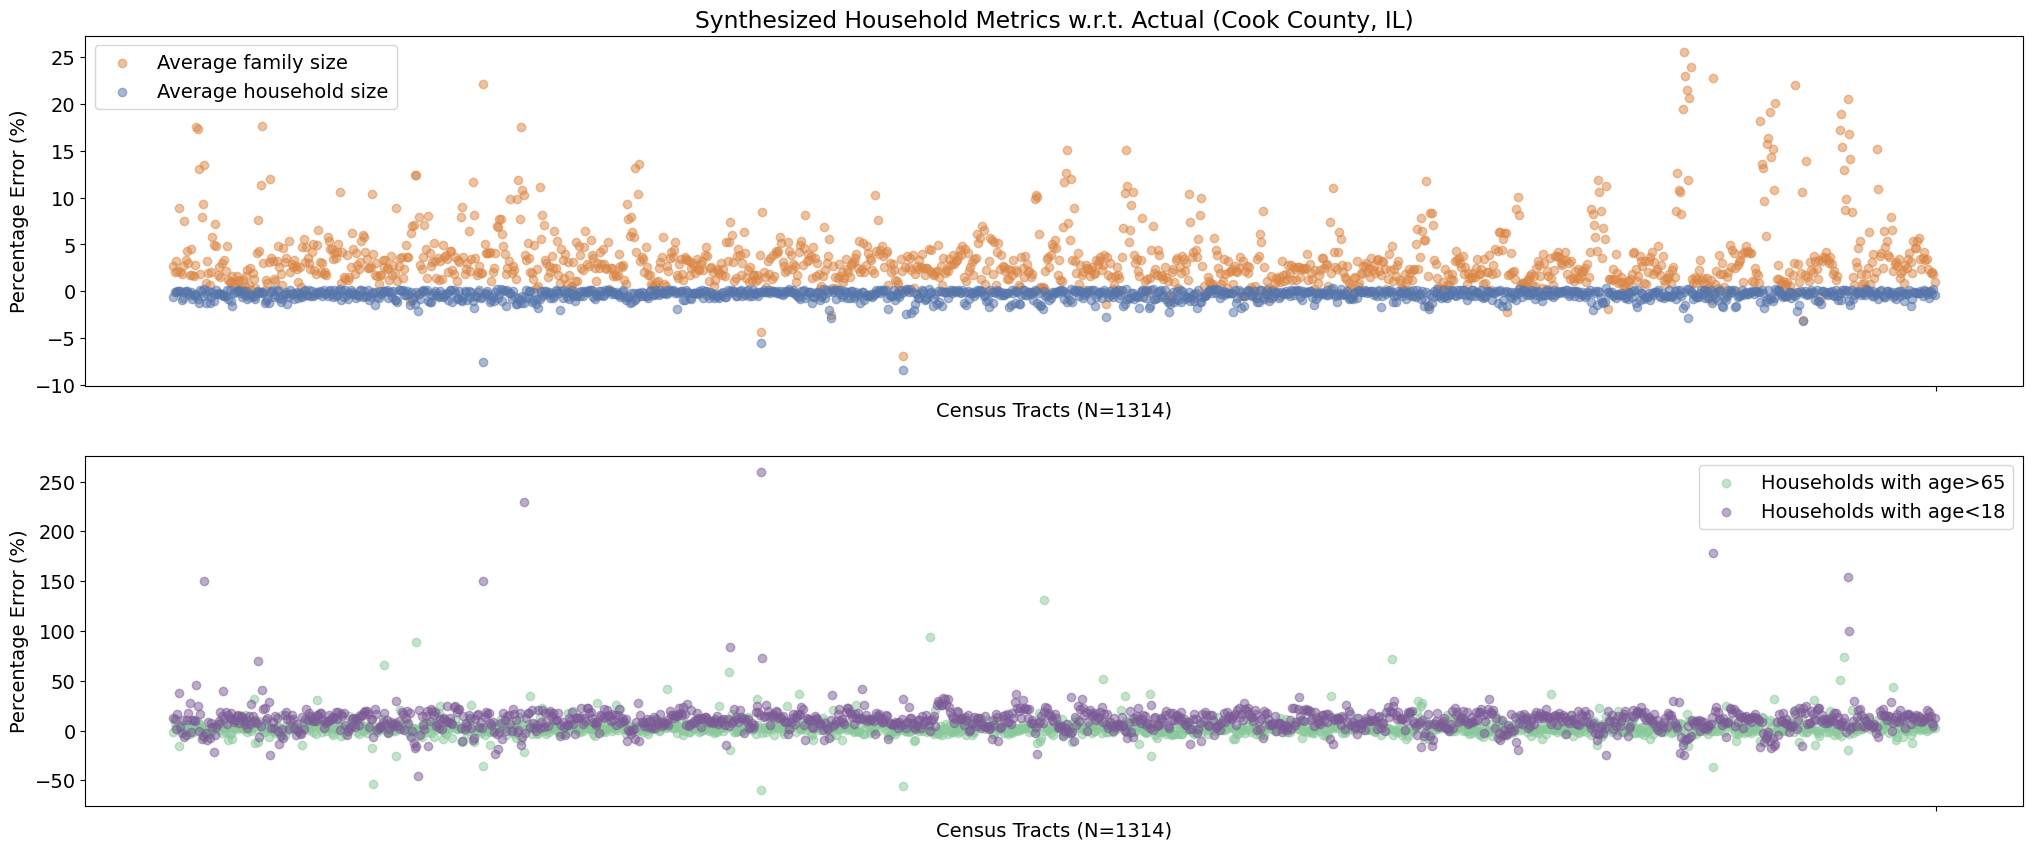

In [10]:
with open('output/errors.pkl', 'rb') as f:
    errors = pd.concat(pickle.load(f),axis=1).T

plt.rcParams.update({'font.size': 14})
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 10))

ax1.scatter(errors.index, errors[['avg_family']], alpha=0.5, color = '#db8644')
ax1.scatter(errors.index, errors[['avg_hh']], alpha=0.5, color = '#5575ab',)
ax1.set(xticklabels='', xticks='', xlabel='Census Tracts (N=1314)',ylabel='Percentage Error (%)',
        title='Synthesized Household Metrics w.r.t. Actual (Cook County, IL)')
ax1.legend(labels=['Average family size', 'Average household size'])

ax2.scatter(errors.index, errors[['senior_hh']], alpha=0.5, color = '#88c999',)
ax2.scatter(errors.index, errors[['minor_hh']], alpha=0.5, color = '#7b5a96',)
ax2.set(xticklabels='', xticks='', xlabel='Census Tracts (N=1314)',ylabel='Percentage Error (%)')
ax2.legend(labels=['Households with age>65', 'Households with age<18'])
plt.savefig("plot/Percentage_errors.png")
plt.show(block=False)

**6.2. Network statistics**

In [204]:
G = load_graph('output/contact_network.gml')
G.set_directed(False)

In [ ]:
print('# of nodes: {}\n# of edges: {}'.format(G.num_vertices(),G.num_edges()))
print('Clustering coefficient: {:.2f}'.format(gt.clustering.global_clustering(G)[0]))
print('Pseudo diameter: {}'.format(int(gt.topology.pseudo_diameter(G)[0])))
print('Average degree: {:.2f}'.format(gt.stats.vertex_average(G, 'total')[0]))
counts,bins = gt.stats.distance_histogram(G,samples=1000)
print('Average path length (N=1000): {:.2f}'.format((counts*bins[:-1]).sum()/counts.sum()))

# of nodes: 5170895
# of edges: 41519643
Clustering coefficient: 0.40
Pseudo diameter: 0
Average degree: 16.06
Average path length (N=1000): 8.29


In [12]:
with open('output/population.pkl','rb') as f:
    people = pd.concat(pickle.load(f))
print('# of employed:',len(people[(people.age >= 18) & (people.wp.notnull())]))
print('# of students:',len(people[people.age < 18]))

# of employed: 2041872
# of students: 1222139


In [144]:
person = 4
i2 = G.vertex(person)
print(label[i2])
neighbors = list(i2.out_neighbors())
neighbors

17031841100i2562


[<Vertex object with index '8337' at 0x7fe41aa11a80>,
 <Vertex object with index '4971326' at 0x7fe41aa11af0>,
 <Vertex object with index '12428' at 0x7fe41aa10ba0>,
 <Vertex object with index '4882273' at 0x7fe41aa11d20>,
 <Vertex object with index '94578' at 0x7fe41aa13290>,
 <Vertex object with index '4803573' at 0x7fe41aa17300>,
 <Vertex object with index '128719' at 0x7fe41aa17ed0>,
 <Vertex object with index '4740603' at 0x7fe41aa17d80>,
 <Vertex object with index '3378881' at 0x7fe41aa17920>]

In [145]:
# Get the vertex 'v' and its neighbors
person = 4
i2 = G.vertex(person)
neighbors = list(i2.out_neighbors())

# Iterate over neighbors and get their neighbors
neighbors_of_neighbors = []
for neighbor in neighbors:
    neighbors_of_neighbor = list(neighbor.out_neighbors())
    neighbors_of_neighbors.extend(neighbors_of_neighbor)

# Add the original neighbors and neighbors of neighbors to a set
vertices_of_interest = set(neighbors + neighbors_of_neighbors)

# Get the subgraph consisting of the vertices of interest
subgraph = G.new_vertex_property('bool')
for vertex in vertices_of_interest:
    subgraph[vertex] = True

subgraph = G.new_vertex_property('bool')
for vertex in vertices_of_interest:
    subgraph[vertex] = True

H = gt.GraphView(G, vfilt=subgraph)

In [209]:
G.get_vertices()
list(G.vertex(4).out_neighbors())
G.vertex_index[4]

4

In [207]:
people

,code,age,sex,friends,hhold,htype,wp,geometry
17031840300i0,5,26.0,m,{},17031840300h116,7,NaN,POINT (-9761167.704 5136249.298)
17031840300i1,13,68.0,m,{},17031840300h93,8,NaN,POINT (-9760023.503 5135878.358)
17031840300i2,3,15.0,m,{},17031840300h198,5,1034,POINT (-9760578.754 5136141.333)
17031840300i3,21,16.0,f,{},17031840300h21,9,1034,POINT (-9760989.843 5135887.726)
17031840300i4,25,38.0,f,{},17031840300h22,9,17031081500w1209,POINT (-9760078.829 5136148.479)
...,...,...,...,...,...,...,...,...
17031824505i6828,26,40.0,f,{},17031824505h1920,0,17031390700w9,POINT (-9769757.182 5103426.594)
17031824505i6829,21,15.0,f,{},17031824505h1365,1,132,POINT (-9769406.889 5103202.346)
17031824505i6830,5,27.0,m,{},17031824505h2333,0,17031835200w115,POINT (-9770876.163 5102312.377)
17031824505i6831,18,2.0,f,{},17031824505h939,3,132,POINT (-9770295.282 5102047.358)


In [201]:
H=0
x = H.get_vertices()[0]
list(H.vertex(4).out_neighbors())


AttributeError: ignored

In [189]:
label[4]

'17031841100i2562'

In [193]:
people.index

Index(['17031840300i0', '17031840300i1', '17031840300i2', '17031840300i3',
       '17031840300i4', '17031840300i5', '17031840300i6', '17031840300i7',
       '17031840300i8', '17031840300i9',
       ...
       '17031824505i6823', '17031824505i6824', '17031824505i6825',
       '17031824505i6826', '17031824505i6827', '17031824505i6828',
       '17031824505i6829', '17031824505i6830', '17031824505i6831',
       '17031824505i6832'],
      dtype='object', length=5170895)

In [188]:
for item in [8337, 4971326, 12428, 4882273, 94578, 4803573, 128719, 4740603, 3378881]:
    print(label[item])

In [167]:

list(h.neighbors(list(h.nodes)[person]))

['17031841100i2085', '17031841100i4871', '17031841100i5280']

In [161]:
# Create a new graph for the subgraph
h = gt.Graph(directed=False)

# Create vertex and edge property maps for the new graph
label = h.new_vertex_property('string')
etype = h.new_edge_property('int')

# Copy the vertices from the GraphView
vertex_map = {}
for v in H.iter_vertices():
    new_v = h.add_vertex()
    vertex_map[v] = new_v
    label[new_v] = H.vp.label[v]

# Copy the edges from the GraphView
for e in H.iter_edges():
    v1 = vertex_map[e[0]]
    v2 = vertex_map[e[1]]
    h.add_edge(v1, v2)
    etype[h.edge(v1, v2)] = H.ep.etype[e]

# Assign the property maps to the new graph
h.vertex_properties['label'] = label
h.edge_properties['etype'] = etype

h.save("output/i2_network.gml")
h = nx.read_gml('output/i2_network.gml')

In [142]:
i2_ = list(h.nodes)[person]

hholdm = [i2_] + [k for k,v in h[i2_].items() if v['etype']=='hhold']
hhold_edges = [e for e in h.edges(hholdm,data=True) if e[2]['etype'] == 1]
work_edges = [e for e in h.edges(hholdm,data=True) if e[2]['etype'] == 2]
school_edges = [e for e in h.edges(hholdm,data=True) if e[2]['etype'] == 3]

['17031841100i2085', '17031841100i4871', '17031841100i5280']

[]

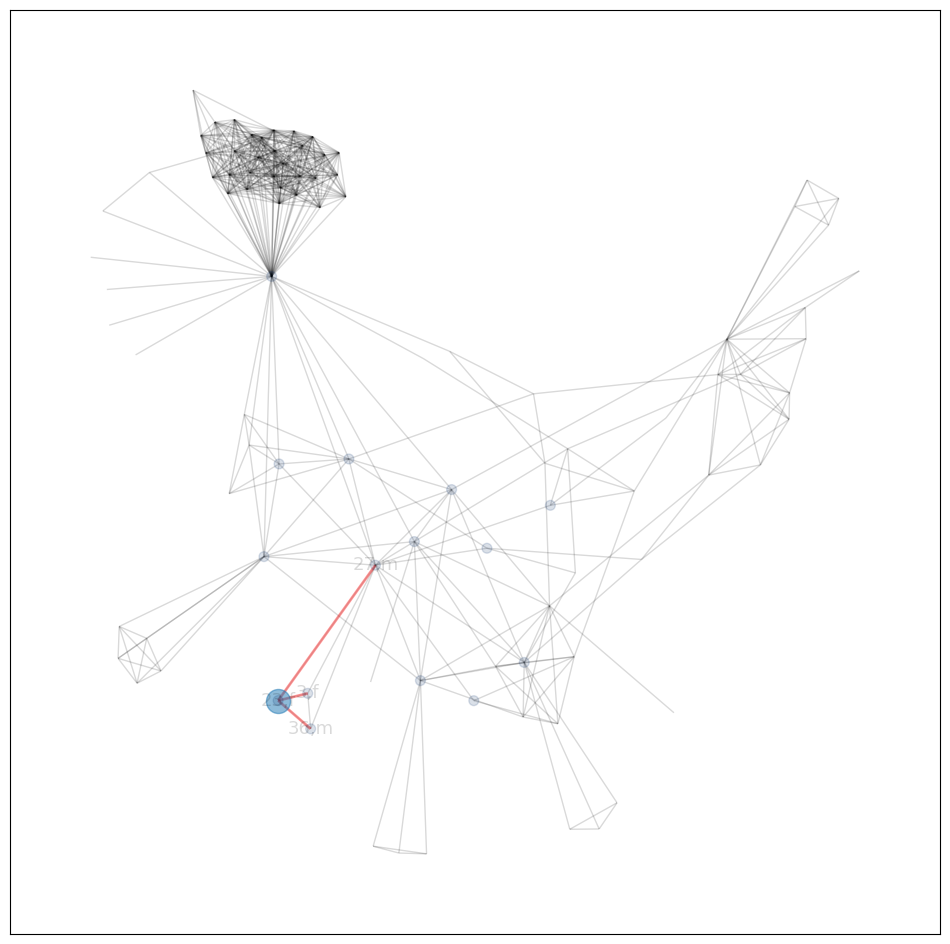

In [196]:
#draw the graph
hop2 = set().union(*[[n]+list(h.neighbors(n)) for n in h.neighbors(i2_)])

labels = people.loc[[i2_] + list(h.neighbors(i2_))]
labels = (labels['age'].astype(int).astype(str)+','+labels['sex']).to_dict()

pos = nx.spring_layout(h)

fig,ax = plt.subplots(figsize=(12, 12));
blues = plt.get_cmap('Blues')
nx.draw_networkx_nodes(h,pos,nodelist=[i2_],alpha=.5)
nx.draw_networkx(h,pos,nodelist=hop2, node_color=[1]*len(hop2),cmap=blues,vmin=0,vmax=1,alpha=0.15,
                        node_size=50,font_size=13, labels=labels, ax=ax)

nx.draw_networkx_edges(h,pos, edge_color='red',edgelist = hhold_edges,width=2,alpha=.4,ax=ax)
nx.draw_networkx_edges(h,pos, edge_color='blue',edgelist = school_edges,width=2,alpha=.4,ax=ax)
nx.draw_networkx_edges(h,pos, edge_color='green',edgelist = work_edges,width=2,alpha=.4,ax=ax)

In [ ]:
hholdm = [i2] + [v for v in G.vertex(i2).all_neighbours() if G.ep.etype[G.edge(i2, v)] == 1]
hhold_edges = [(int(e.source()), int(e.target())) for e in subgraph.edges() if subgraph.ep.etype[e] == 1]
work_edges = [(int(e.source()), int(e.target())) for e in subgraph.edges() if subgraph.ep.etype[e] == 2]
school_edges = [(int(e.source()), int(e.target())) for e in subgraph.edges() if subgraph.ep.etype[e] == 3]

In [ ]:
# Assuming you have the necessary data defined

# Create a single figure with a single subplot
fig, ax = plt.subplots(figsize=(10, 10))
fig.suptitle("Ego Network Visualization")

# Compute the vertex positions using the sfdp_layout algorithm
pos = gt.sfdp_layout(subgraph)

# Draw the ego vertex separately with a different color and transparency
ego_vertex = subgraph.vertex(i2)
vertex_color = [1 if v == ego_vertex else 0 for v in subgraph.vertices()]
vertex_size = 10
vertex_fill_opacity = 0.5

# Assign colors to edges based on edge property
edge_colors = []
for edge in subgraph.edges():
    etype = subgraph.ep.etype[edge]
    if etype == 1:
        edge_colors.append('blue')
    elif etype == 2:
        edge_colors.append('green')
    elif etype == 3:
        edge_colors.append('red')

# Draw the graph with colored edges
gt.graph_draw(subgraph, pos=pos, vertex_fill_color=vertex_color, vertex_size=vertex_size,
              vertex_fill_opacity=vertex_fill_opacity, edge_color=edge_colors,
              edge_pen_width=2, edge_opacity=0.5, edge_alpha=0.3, ax=ax)

# Show the figure
plt.show()


In [ ]:
edge_colors

PropertyArray([3., 1., 1., ..., 3., 3., 3.])

In [ ]:
hhold_edges

In [ ]:
[len(list(G.vertex(i).out_neighbors())) for i in G.get_vertices()[:]]

[0,
 0,
 43,
 39,
 9,
 7,
 0,
 47,
 12,
 48,
 45,
 11,
 0,
 0,
 42,
 13,
 9,
 0,
 51,
 0,
 11,
 0,
 0,
 0,
 11,
 11,
 0,
 0,
 13,
 0,
 0,
 0,
 2,
 11,
 11,
 0,
 0,
 0,
 0,
 36,
 11,
 13,
 0,
 46,
 0,
 48,
 0,
 0,
 49,
 51,
 14,
 0,
 0,
 0,
 14,
 50,
 9,
 0,
 10,
 9,
 0,
 0,
 0,
 0,
 42,
 12,
 7,
 0,
 0,
 0,
 12,
 13,
 0,
 10,
 0,
 6,
 9,
 9,
 11,
 12,
 0,
 0,
 41,
 0,
 51,
 0,
 0,
 11,
 41,
 13,
 0,
 9,
 12,
 11,
 11,
 44,
 9,
 42,
 3,
 11,
 0,
 0,
 0,
 10,
 2,
 11,
 0,
 0,
 0,
 0,
 0,
 11,
 0,
 0,
 0,
 6,
 42,
 12,
 41,
 10,
 39,
 0,
 10,
 42,
 9,
 0,
 47,
 9,
 0,
 0,
 0,
 0,
 10,
 11,
 46,
 10,
 0,
 0,
 0,
 0,
 10,
 0,
 12,
 38,
 12,
 0,
 10,
 10,
 40,
 0,
 0,
 2,
 0,
 0,
 9,
 40,
 12,
 0,
 9,
 4,
 0,
 16,
 11,
 43,
 0,
 0,
 0,
 40,
 0,
 0,
 0,
 0,
 38,
 39,
 0,
 11,
 45,
 13,
 6,
 12,
 0,
 0,
 3,
 14,
 0,
 0,
 13,
 0,
 0,
 0,
 41,
 15,
 16,
 0,
 13,
 0,
 5,
 36,
 17,
 16,
 41,
 13,
 40,
 0,
 0,
 10,
 10,
 5,
 0,
 3,
 42,
 46,
 0,
 6,
 12,
 41,
 2,
 12,
 13,
 12,
 3,
 15,
 6,
 17,
 1

In [ ]:
# Start with a single individual
i2 = G.vertex(2)

# Get friends + friends of friends (FoF)
hop2 = [n for neighbor in G.get_out_neighbours(i2) for n in G.get_out_neighbours(neighbor)]
hop2.append(i2)
hop2 = list(set(hop2))

# Create the ego network graph
H = gt.GraphView(G, vfilt=lambda v: v in hop2)

hholdm = [i2] + [v for v in G.vertex(i2).all_neighbours() if G.ep.etype[G.edge(i2, v)] == 'hhold']
hhold_edges = [(int(e.source()), int(e.target())) for e in H.edges() if H.ep.etype[e] == 'hhold']
work_edges = [(int(e.source()), int(e.target())) for e in H.edges() if H.ep.etype[e] == 'work']
school_edges = [(int(e.source()), int(e.target())) for e in H.edges() if H.ep.etype[e] == 'school']


<ipython-input-63-4623a8e35456>:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  H = gt.GraphView(G, vfilt=lambda v: v in hop2)


In [ ]:
#prepare a 2-hops (FoF) ego network
g = nx.read_gml('output/contact_network.gml')
#start with a single individual
i0 = '17031840300i0'
#get friends + friends of friends (FoF)
hop2 = set().union(*[[n]+g.neighbors(n) for n in g.neighbors(i0)])
g2 = nx.Graph(g.edges(hop2,data=True))
hholdm = [i0] + [k for k,v in g[i0].items() if v['etype']=='hhold']
hhold_edges = [e for e in g2.edges(hholdm,data=True) if e[2]['etype'] == 'hhold']
work_edges = [e for e in g2.edges(hholdm,data=True) if e[2]['etype'] == 'work']
school_edges = [e for e in g2.edges(hholdm,data=True) if e[2]['etype'] == 'school']

In [ ]:
#draw the graph
labels = people.loc[[i0] + g.neighbors(i0)] #[k for k,v in g[i0].items()]
labels = (labels['age'].astype(str)+','+labels['sex']).to_dict()

pos = nx.spring_layout(g2)

fig,ax = plt.subplots();
blues = plt.get_cmap('Blues')
nx.draw_networkx_nodes(g2,pos,nodelist=[i0],alpha=.5)
nx.draw_networkx(g2,pos,nodelist=hop2, node_color=[1]*len(hop2),cmap=blues,vmin=0,vmax=1,alpha=0.15,
                        node_size=50,font_size=13, labels=labels, ax=ax)

nx.draw_networkx_edges(g2,pos, edge_color='red',edgelist = hhold_edges,width=2,alpha=.3,ax=ax)
nx.draw_networkx_edges(g2,pos, edge_color='blue',edgelist = school_edges,width=2,alpha=.3,ax=ax)
nx.draw_networkx_edges(g2,pos, edge_color='green',edgelist = work_edges,width=2,alpha=.3,ax=ax)
ax.axis('off');